## Imports

In [1]:
import os
import pathlib
import cv2
import logging
logging.disable(logging.WARNING)

import matplotlib
import matplotlib.pyplot as plt
import time

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

import serial

from IPython.display import Audio
from IPython.core.display import display

tf.get_logger().setLevel('ERROR')


/var/folders/y7/w740pwz129s5nm6pf97h2zs40000gn/T/ipykernel_93667/2253195012.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


## Select Pre-trained Model

In [2]:
# @title Model Selection { display-mode: "form", run: "auto" }
ALL_MODELS = {
'material_model' : 'material/saved_model/saved_model/',
'material_form_model' : 'material_form/saved_model/saved_model/',
}
model_display_name = 'material_model' # @param ['material_model','material_form_model','plastic_model']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))
PATH_TO_LABELS = './models/official/projects/waste_identification_ml/pre_processing/config/data/material_labels.pbtxt'
print('Labels selected for\n', model_display_name)

print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')


Selected model:material_model
Model Handle at TensorFlow Hub: material/saved_model/saved_model/
Labels selected for
 material_model
loading model...
model loaded!


## Arduino Response

In [3]:
def ultrasonic_activate():
    arduino = serial.Serial('/dev/cu.usbmodem1101', 9600) # Change com3 when testing
    print('Established serial connection to Arduino')
    arduino_data = arduino.readline()
    
    decoded_values = str(arduino_data[0:len(arduino_data)].decode("utf-8"))
    print(f"Collected data from arduino: {decoded_values}")
    if not decoded_values:
        arduino.close()
        return False
    arduino.close()
    return True
    

## Webcam to take picture

In [4]:
# camera = cv2.VideoCapture(0)

In [5]:
def take_and_save_photo():
    ret, frame = camera.read()
    plt.imshow(frame)
    plt.show()
    camera.release()
    cv2.imwrite("photo.png", frame)

    # path to an image
    IMAGES_FOR_TEST["Image1"] = "photo.png"

In [6]:
# Inputs to preprocess functions

def normalize_image(image,
                    offset=(0.485, 0.456, 0.406),
                    scale=(0.229, 0.224, 0.225)):
  """Normalizes the image to zero mean and unit variance."""
  with tf.name_scope('normalize_image'):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    offset = tf.constant(offset)
    offset = tf.expand_dims(offset, axis=0)
    offset = tf.expand_dims(offset, axis=0)
    image -= offset

    scale = tf.constant(scale)
    scale = tf.expand_dims(scale, axis=0)
    scale = tf.expand_dims(scale, axis=0)
    image /= scale
    return image

    
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (1, h, w, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


def build_inputs_for_segmentation(image):
  """Builds segmentation model inputs for serving."""
  # Normalizes image with mean and std pixel values.
  image = normalize_image(image)
  return image

In [7]:
def loading_image():
    #@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
    selected_image = 'Image1' # @param ['Image1']

    image_path = IMAGES_FOR_TEST[selected_image]
    Image.open(image_path)
    image_np = load_image_into_numpy_array(image_path)

    print('min:',np.min(image_np[0]), 'max:', np.max(image_np[0]))
    plt.figure(figsize=(24,32))
    plt.imshow(image_np[0])
    #plt.show()
    return image_np

In [8]:
def preprocessing_image(image_np):
    # get an input size of images on which an Instance Segmentation model is trained
    hub_model_fn = hub_model.signatures["serving_default"]
    height=hub_model_fn.structured_input_signature[1]['inputs'].shape[1]
    width = hub_model_fn.structured_input_signature[1]['inputs'].shape[2]
    input_size = (height, width)
    print(input_size)
    # apply pre-processing functions which were applied during training the model
    image_np_cp = cv2.resize(image_np[0], input_size[::-1], interpolation = cv2.INTER_AREA)
    image_np = build_inputs_for_segmentation(image_np_cp)
    image_np = tf.expand_dims(image_np, axis=0)
    image_np.get_shape()
    # display pre-processed image
    plt.figure(figsize=(24,32))
    plt.imshow(image_np[0])
    plt.show()
    return image_np, hub_model_fn

## Use ML model to make inference

In [9]:
def inference(image_np, hub_model_fn):
    # running inference
    results = hub_model_fn(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    return result

## Send Arduino yeet or drop

In [10]:
def full_send(to_yeet_or_not_to_yeet):
    arduino = serial.Serial('/dev/cu.usbmodem1101', 9600)
    time.sleep(2)
    if to_yeet_or_not_to_yeet == 'y':
        arduino.write(b'y')
    else:
        arduino.write(b'd')
    arduino.close()

## Determine yeet or drop

In [11]:
def play_sound():
    display(Audio('getdatgarbageouttahere.mp3', autoplay=True))

def determine_yeet(result):

    filtered_results = []
    trash_materials = [2,3,4,5,7,8,9]

    for i in range(result['detection_classes'][0].size):
        if result['detection_scores'][0][i] > 0.6:
            filtered_results.append(result['detection_classes'][0][i])

    # Output result and play sound
    if any(i in filtered_results for i in trash_materials):
        print("yeet") # Change to send data to arduino
        full_send('y')
        play_sound();
    else:
        print("drop") # Change to send data to arduino 
        full_send('d')

## Initialize Camera

In [14]:
camera = cv2.VideoCapture(0)

# Main Function

Established serial connection to Arduino
Collected data from arduino: s



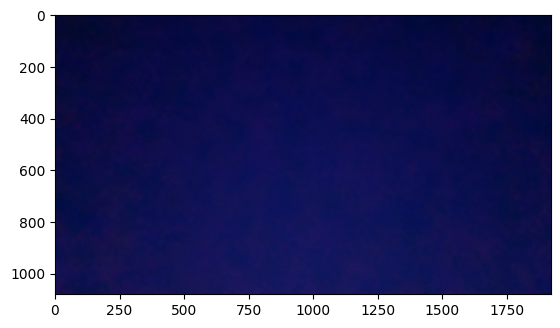

min: 0 max: 102
(512, 1024)


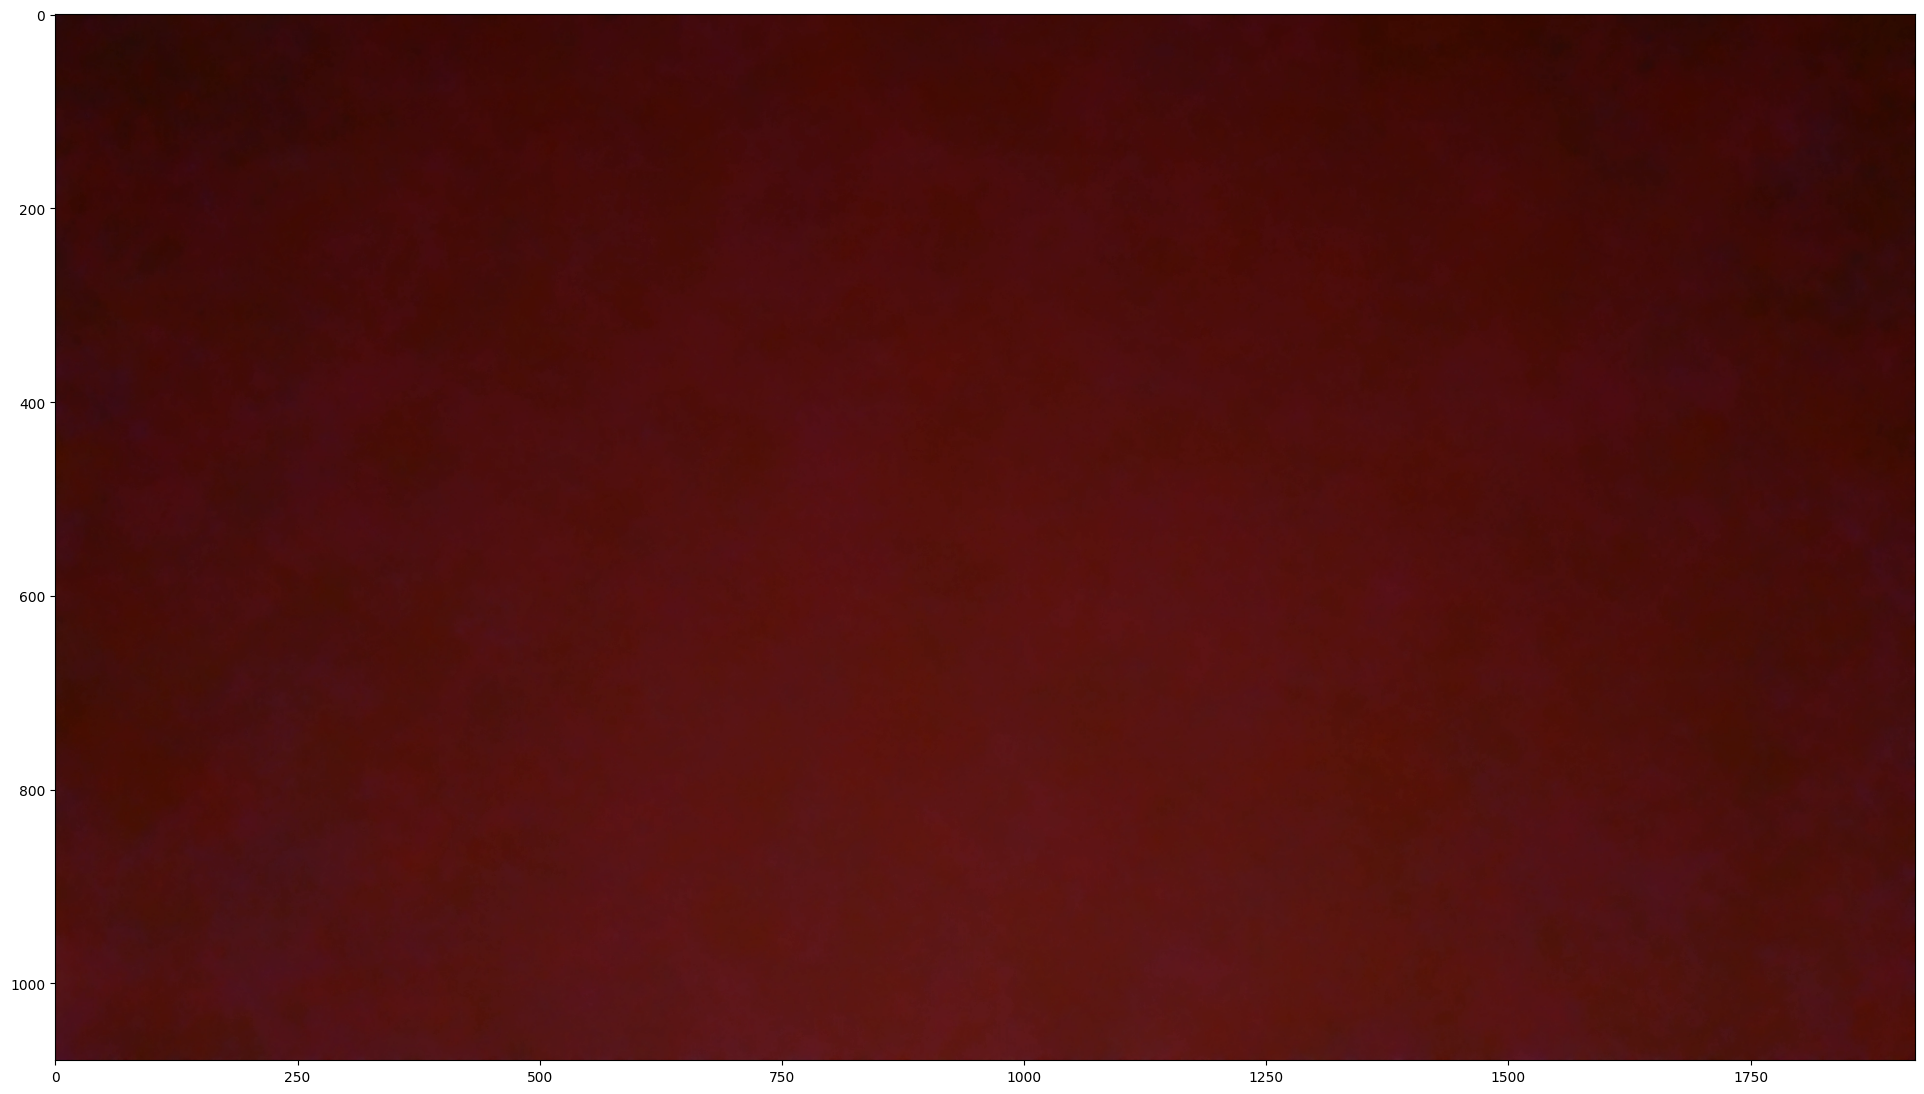

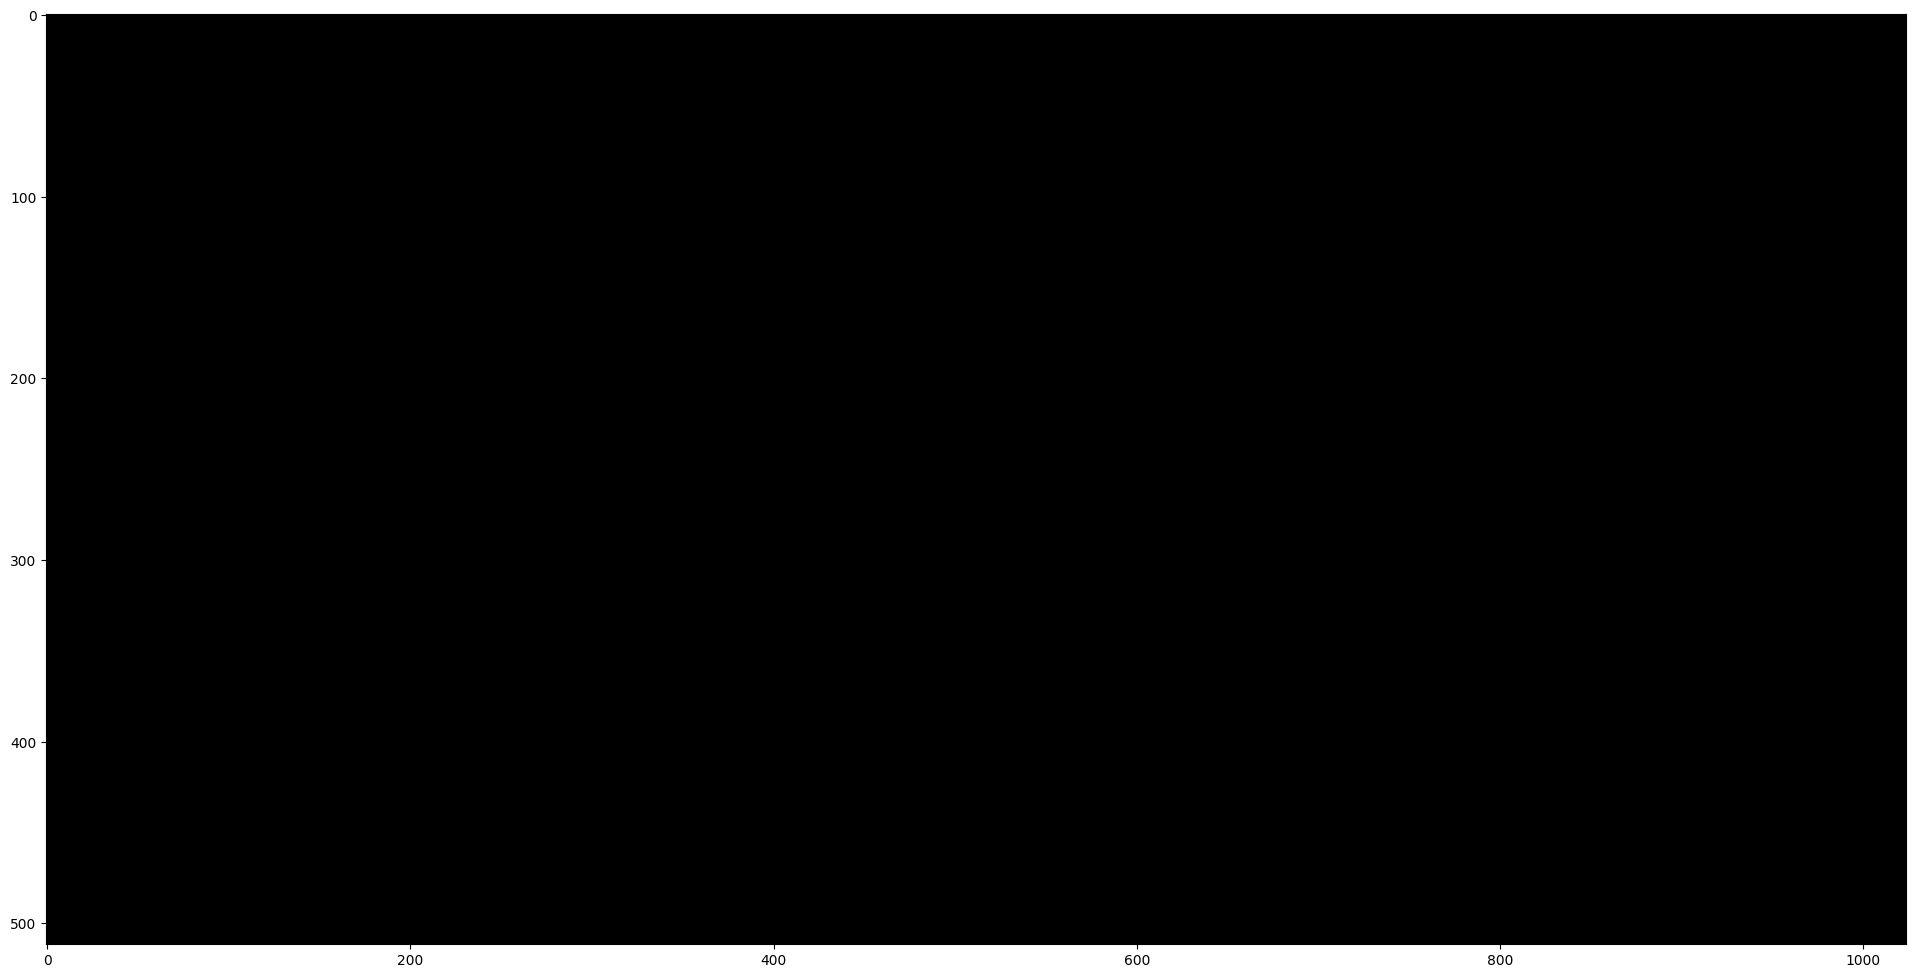

drop


In [15]:
list_values = []
IMAGES_FOR_TEST = {}
while True:
    if ultrasonic_activate():
        time.sleep(1)
        take_and_save_photo()
        image_np = loading_image()
        image_np_processed, hub_model_fn = preprocessing_image(image_np)
        result = inference(image_np_processed, hub_model_fn)
        determine_yeet(result)
        break
    else:
        print("Nothing detected")
    time.sleep(2)